In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import open3d as o3d
%matplotlib widget

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# open a file, where you stored the pickled data
file = open('/home/lucas/Documents/GitLab/dmot/sparse_mapping/segment_track/demo/data_hist.pkl', 'rb')
# file = open('/home/lucas/Documents/GitLab/dmot/sparse_mapping/segment_track/demo/segments_pcd', 'rb')
# dump information to that file
observation_history = pickle.load(file)

# close the file
file.close()

In [ ]:
print(observation_history[0])

In [3]:
tracker = observation_history[0]
segments = tracker.segments

In [7]:
pcd_list = []
pcd_raw_list = []
pcd_downsampled = []
for seg in tracker.segments + tracker.segment_graveyard:
    seg_points = seg.points
    if seg_points is not None:
        num_pts = seg_points.shape[0]
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(seg_points)
        rand_color = np.random.uniform(0, 1, size=(1,3))
        rand_color = np.repeat(rand_color, num_pts, axis=0)
        pcd.colors = o3d.utility.Vector3dVector(rand_color)
        pcd_list.append(pcd)
        pcd_raw_list.append(seg_points)
o3d.visualization.draw_geometries(pcd_list)

In [8]:
print(len(pcd_list))

55


In [14]:
# o3d.visualization.draw_geometries([pcd_list[i] for i in [10, 12, 13, 14, 16, 17]])
o3d.visualization.draw_geometries([pcd_list[i] for i in [34, 35, 36, 37, 38]])

In [15]:
data_aggregated = []
for i in [34, 35, 36, 37, 38]:
    data_aggregated.extend(pcd_raw_list[i])
# data = pcd_raw_list[10]pcd_raw_list[11]
data_aggregated = np.array(data_aggregated)
print(data_aggregated.shape)

(6888, 3)


In [43]:
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                      zoom=0.3412,
                                      front=[0.4257, -0.2125, -0.8795],
                                      lookat=[2.6172, 2.0475, 1.532],
                                      up=[-0.0694, -0.9768, 0.2024])

In [38]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(data_aggregated)

In [98]:
cl, ind = pcd.remove_radius_outlier(nb_points=30, radius=0.2)
# display_inlier_outlier(pcd_downsampled, ind)
inlier_cloud = pcd.select_by_index(ind)
o3d.visualization.draw_geometries([inlier_cloud])

In [74]:
print(np.asarray(inlier_cloud.points).shape)

(6586, 3)


In [107]:
pcd_downsampled = inlier_cloud.voxel_down_sample(voxel_size=0.1)
# pcd_downsampled = inlier_cloud.uniform_down_sample(15)
o3d.visualization.draw_geometries([pcd_downsampled])

In [104]:
print(np.asarray(pcd_downsampled.points).shape)

(1870, 3)


In [109]:
pcd_downsampled_dd = pcd_downsampled.uniform_down_sample(5)
print(np.asarray(pcd_downsampled_dd.points).shape)

(374, 3)


In [110]:
data_pcd = np.asarray(pcd_downsampled_dd.points)

04-23 12:08:35 No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


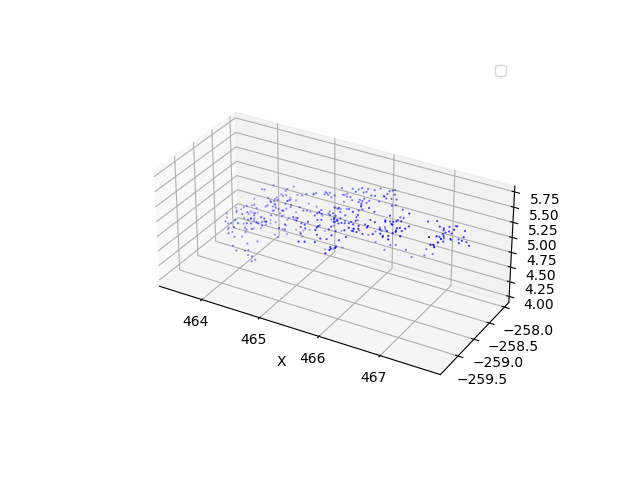

In [111]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
ax1.scatter(data_pcd[:, 0], data_pcd[:, 1], data_pcd[:, 2], 
            zdir='z', c= 'blue', s=0.3)
ax1.set_aspect('equal')
ax1.set_xlabel("X")
ax1.legend()

In [ ]:
'''
IF loaded from segments_pcd
'''
# dataset = []
# for obs in observation_history:
#     # print(obs["seg_id"])
#     if obs["seg_id"] in [4, 30, 74, 103]:
#         print(obs["seg_id"])
#         dataset.append(obs["seg_pcd"])
# data = dataset[22]

In [112]:
data_processed = np.zeros(data_pcd.shape)

In [113]:
data_processed[:, 0] = -(data_pcd[:, 0] - 466)/4
data_processed[:, 1] = (data_pcd[:, 1] + 259)/4
data_processed[:, 2] = (data_pcd[:, 2] - 4.5)/4

04-23 12:08:45 No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


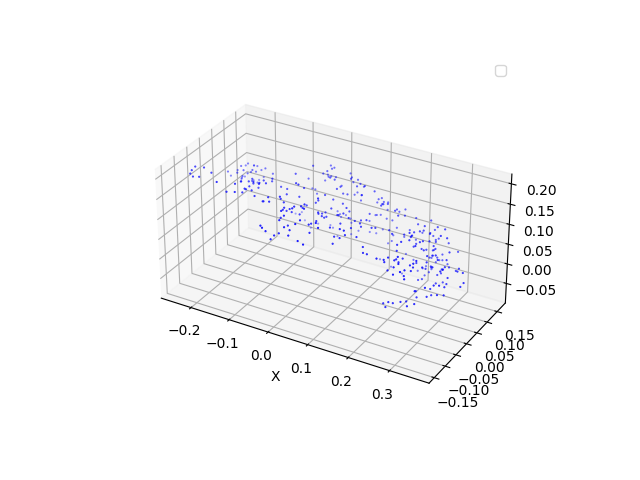

In [114]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
ax1.scatter(data_processed[:, 0], data_processed[:, 1], data_processed[:, 2], 
            zdir='z', c= 'blue', s=0.3)
ax1.set_aspect('equal')
ax1.set_xlabel("X")
ax1.legend()

In [87]:
import torch
from equiv_reg import misc, config
from equiv_reg.checkpoints import CheckpointIO
from equiv_reg.transforms import apply_rot, gen_randrot
from equiv_reg.register_utils import *
from torch.nn import functional as F

In [ ]:
equireg_path = "/home/lucas/Documents/GitLab/dmot/sparse_mapping/equivreg/"
cfg = misc.load_config(equireg_path + 'configs/test/reg_ideal.yaml')

is_cuda = (torch.cuda.is_available())
device = torch.device("cuda" if is_cuda else "cpu")
out_dir, gen_dir = config.cfg_f_out_test(cfg)

model = config.cfg_model(cfg, device)
checkpointio = CheckpointIO(model, checkpoint_dir=out_dir)
checkpointio.load(cfg['testing']['model_file'])

In [ ]:
model.eval()

In [91]:
### configure dataset
train_dataset, val_dataset, train_loader, val_loader, vis_loader, duo_loader = config.cfg_dataloader(cfg)
batch_size = 1
test_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, num_workers=3, shuffle=True)
test_iter = iter(test_loader)

WARNING - 2024-04-23 12:04:42,522 - dataset - Using input categories: ['car']!
DEBUG - 2024-04-23 12:04:42,531 - dataset - Constructed paired dataset:sim3_params=Sim3SimulationParams(rot_magmax=60, rot_axis=array([0., 0., 1.], dtype=float32), scale_min=0.1, scale_max=2.0, translation_mag=1.0),duo_mode=False,reg_benchmark_mode=False,pcl_noise=0.01,resamp_noise=False,partial_view_params=PartialViewParams(num_output_points=512, camera_dist=2.0, camera_min_z=0.0, camera_max_z=0.0, multiplier=100.0, debug=True)
WARNING - 2024-04-23 12:04:42,531 - dataset - Using input categories: ['car']!
DEBUG - 2024-04-23 12:04:42,533 - dataset - Constructed paired dataset:sim3_params=Sim3SimulationParams(rot_magmax=60, rot_axis=array([0., 0., 1.], dtype=float32), scale_min=0.1, scale_max=2.0, translation_mag=1.0),duo_mode=False,reg_benchmark_mode=False,pcl_noise=0.01,resamp_noise=False,partial_view_params=PartialViewParams(num_output_points=512, camera_dist=2.0, camera_min_z=0.0, camera_max_z=0.0, multip

In [92]:
data_equiv = next(test_iter)

In [115]:
inputs = torch.from_numpy(data_processed).unsqueeze(dim=0).to(torch.float).to(device)
points_iou = points_iou = data_equiv['points_iou'].to(device)
# points_iou = torch.from_numpy(random_inputs).unsqueeze(dim=0).to(torch.float).to(device)
with torch.no_grad():
    p_out = model(points_iou, inputs, sample=False)


THRESHOLD = 0.5
occ_iou_hat_np = (p_out.probs >= THRESHOLD).cpu().numpy()
indices_pred = np.nonzero(occ_iou_hat_np)[1]

points_ = points_iou.to('cpu').numpy()
print(points_.shape)
points_pred = points_[0, indices_pred, :]
inputs_np = inputs.to('cpu').numpy()
print(inputs_np.shape)
print(f"Shape of predicted occupied points: {points_pred.shape}")


(1, 100000, 3)
(1, 374, 3)
Shape of predicted occupied points: (7319, 3)


In [94]:
model.equivariance_mode

'SE3'

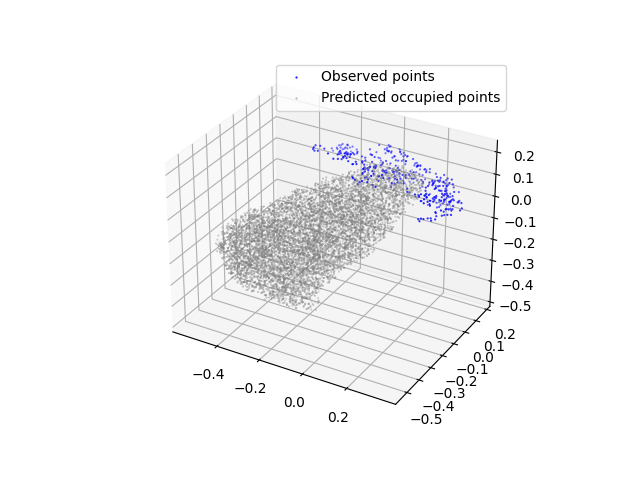

In [116]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
ax1.scatter(inputs_np[0, :, 0], inputs_np[0, :, 1], inputs_np[0, :, 2], 
            zdir='z', c= 'blue', s=0.3, label='Observed points')
ax1.scatter(points_pred[:, 0], points_pred[:, 1], points_pred[:, 2], 
            zdir='z', c= 'gray', s=0.1, label='Predicted occupied points')
ax1.set_aspect('equal')
ax1.legend()